In [25]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pygeohash
import folium
import math
from matplotlib import pyplot as plt

def create_bins_10(df, col):
    re = df.copy()
    re[col+'_bin'] = re[col].apply(lambda x: int(math.floor(x/10)*10))
    return re

# Exploration & Analysis
Now we analyze the results to see look for correlations at intersesctions:
* Max Road Speed
* Max Road Width
* Max Road Width to Max Lane Count Ratio
* Max Road Speed & Max Road Width

In [107]:
crime_df = pd.read_json('./prepared_data/crash_data.json', orient='records')
intersection_df = pd.read_json('./prepared_data/intersection_info.json', orient='records') 
data_df = pd.read_json('./prepared_data/prepared_data.json', orient='records')

In [111]:
data_df[data_df['max_width_to_lane_ratio'].isna()][['location', 'latitude', 'longitude', 'geohash', '

,objectid,case_no,date,description,location,city,latitude,longitude,globalid,geohash,...,street_types,owners,max_width,min_width,max_speed_limit,min_speed_limit,max_lanes,min_lanes,max_width_to_lane_ratio,min_width_to_lane_ratio
4,24,202200361004,2022-12-08 00:04:00+00:00,MVC - PI,GUELPH LI,BURLINGTON,43.352178,-79.803863,6c97ac07-1a63-41b5-95f8-725dea1811f4,hcyf42pv,...,[MAJOR],"[MTO, ROH]",42.0,12.0,60,50,9,0,NaN,4.666667
6,29,202200366735,2022-12-08 16:15:00+00:00,MVC - HIT & RUN,GUELPH LI,BURLINGTON,43.352178,-79.803863,2cc4e005-eb9c-40d6-af1a-31488d1f6f9a,hcyf42pv,...,[MAJOR],"[MTO, ROH]",42.0,12.0,60,50,9,0,NaN,4.666667
8,31,202200367839,2022-12-14 22:20:00+00:00,MVC - PI,GUELPH LI,BURLINGTON,43.352178,-79.803863,25e4a0bc-6bb9-4f4d-a64b-3b79b1b51638,hcyf42pv,...,[MAJOR],"[MTO, ROH]",42.0,12.0,60,50,9,0,NaN,4.666667
9,32,202200367890,2022-12-14 23:25:00+00:00,MVC - HIT & RUN,GUELPH LI,BURLINGTON,43.352178,-79.803863,58a8b2b4-2072-49d2-b348-f4e483df65c7,hcyf42pv,...,[MAJOR],"[MTO, ROH]",42.0,12.0,60,50,9,0,NaN,4.666667
44,170,202300121402,2023-04-20 14:35:00+00:00,MVC - PI,GUELPH LI,BURLINGTON,43.352178,-79.803863,11d3c91a-350f-4df6-a99f-47a4b3ea6da7,hcyf42pv,...,[MAJOR],"[MTO, ROH]",42.0,12.0,60,50,9,0,NaN,4.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,12571,202300366065,2023-11-23 21:57:49+00:00,MVC - PI,PLAINS RD W,BURLINGTON,43.294842,-79.890440,32fb2193-9238-4b2c-97f4-d16dcec3758d,hcyc90qk,...,[MAJOR],[MTO],12.0,12.0,80,50,0,0,NaN,NaN
1074,13267,202300074262,2023-03-08 23:33:00+00:00,MVC - PI,ALAYNE BRYK WY,BURLINGTON,43.311392,-79.858857,63567805-1435-477f-bdce-f3e605de5ec4,hcyc9w4k,...,[MAJOR],"[MTO, COB]",30.0,20.0,50,50,4,0,NaN,5.000000
1095,13831,202300276459,2023-08-29 17:19:00+00:00,MVC - HIT & RUN,403 HWY,BURLINGTON,43.312032,-79.859808,e22c4a8f-1bc2-42a7-9360-cfd92dd45e57,hcyc9w4k,...,[MAJOR],"[MTO, COB]",30.0,20.0,50,50,4,0,NaN,5.000000
1096,13833,202300293403,2023-09-12 16:50:00+00:00,MVC - PI,403 HWY,BURLINGTON,43.312032,-79.859808,5c332532-35b8-4dd8-b124-e702eb27111f,hcyc9w4k,...,[MAJOR],"[MTO, COB]",30.0,20.0,50,50,4,0,NaN,5.000000


<AxesSubplot:>

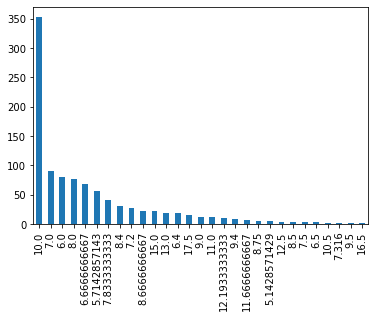

In [116]:
data_df['max_width_to_lane_ratio'].value_counts().plot.bar()

First we'll find the number of intersections with certain values for normalization later.

In [4]:
stats = dict()
stats_cols = ['max_width', 'min_width', 'max_speed_limit', 'min_speed_limit', 'max_lanes', 'min_lanes']
for col in stats_cols:
    stats[col] = intersection_df[col].value_counts()
for col in stats_cols:
    stats[col + '_bin'] = create_bins_10(intersection_df, col)[col+'_bin'].value_counts()

## Road Speeds
We'll take a naive look first at the normalized values for road speeds. We'll also be bucketing the widths into 10s. (e.g. 10m-20m, 20m-30m, etc.)

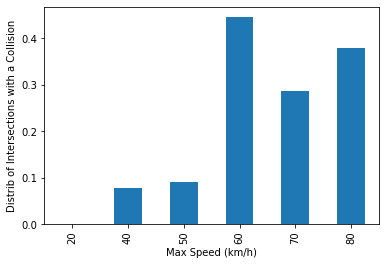

In [87]:
# Is there a collision?
(data_df[['max_speed_limit', 'geohash']].drop_duplicates()['max_speed_limit'].value_counts()/stats['max_speed_limit']).plot.bar()
plt.xlabel('Max Speed (km/h)')
plt.ylabel('Distrib of Intersections with a Collision')
plt.show()

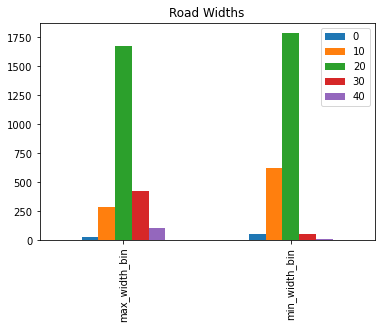

In [106]:
# Max and Min Width Distribution
pd.DataFrame([stats['max_width_bin'], stats['min_width_bin']]).sort_index().plot.bar()
plt.title("Road Widths")
plt.show()

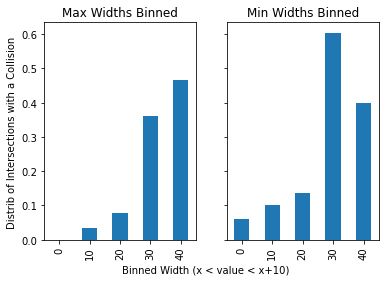

In [86]:
# Is there a collision?
max_width_binned = create_bins_10(data_df[['max_width', 'geohash']].drop_duplicates(), 'max_width')
min_width_binned = create_bins_10(data_df[['min_width', 'geohash']].drop_duplicates(), 'min_width')
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
(max_width_binned['max_width_bin'].value_counts()/stats['max_width_bin']).plot.bar(ax=axes[0])
axes[0].title.set_text("Max Widths Binned")
(min_width_binned['min_width_bin'].value_counts()/stats['min_width_bin']).plot.bar(ax=axes[1])
axes[1].title.set_text("Min Widths Binned")
del max_width_binned
del min_width_binned
fig.text(0.04, 0.5, 'Distrib of Intersections with a Collision', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Binned Width (x < value < x+10)', ha='center')
plt.show()

Despite intersections with max widths between 40 and 50 metres making up a minority, there a disproportionately large number of these intersections have collisions. \
Regarding min widths, more intersections at 30 to 50 metres have collisions than expected.

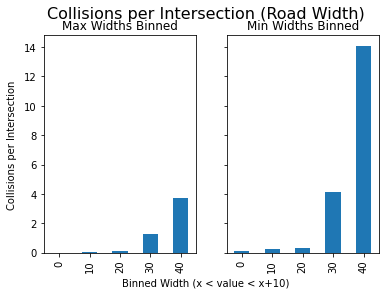

In [101]:
# Collisions per intersection
max_width_binned = create_bins_10(data_df[['max_width', 'geohash']], 'max_width')
min_width_binned = create_bins_10(data_df[['min_width', 'geohash']], 'min_width')
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
(max_width_binned['max_width_bin'].value_counts()/stats['max_width_bin']).plot.bar(ax=axes[0])
axes[0].title.set_text("Max Widths Binned")
(min_width_binned['min_width_bin'].value_counts()/stats['min_width_bin']).plot.bar(ax=axes[1])
axes[1].title.set_text("Min Widths Binned")
del max_width_binned
del min_width_binned
fig.text(0.04, 0.5, 'Collisions per Intersection', va='center', rotation='vertical')
fig.suptitle("Collisions per Intersection (Road Width)", fontsize=16)
fig.text(0.5, 0.01, 'Binned Width (x < value < x+10)', ha='center')
plt.show()

As expected, there are also a higher collisions per intersection the wider the width of the intersecting roads. 

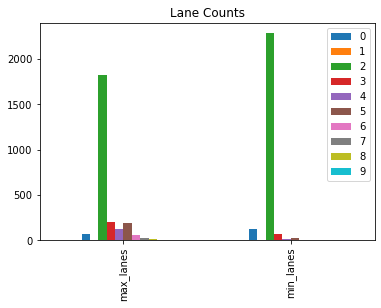

In [103]:
pd.DataFrame([stats['max_lanes'], stats['min_lanes']]).sort_index().plot.bar()
plt.title("Lane Counts")
plt.show()

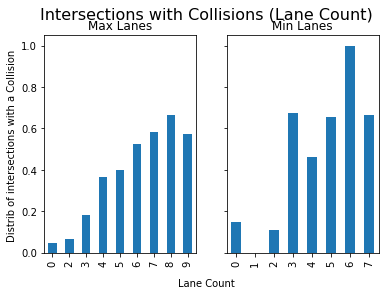

In [100]:
# Is there a collision?
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
(data_df[['max_lanes', 'geohash']].drop_duplicates()['max_lanes'].value_counts()/stats['max_lanes']).plot.bar(ax=axes[0])
axes[0].title.set_text("Max Lanes")
(data_df[['min_lanes', 'geohash']].drop_duplicates()['min_lanes'].value_counts()/stats['min_lanes']).plot.bar(ax=axes[1])
axes[1].title.set_text("Min Lanes")
fig.text(0.04, 0.5, 'Distrib of intersections with a Collision', va='center', rotation='vertical')
fig.suptitle("Intersections with Collisions (Lane Count)", fontsize=16)
fig.text(0.5, 0.01, 'Lane Count', ha='center')
plt.show()

Again, despite so few intersections having a high number of max lanes, a larger proportion of them have had a motor vehicle collision. A pattern is less evident when looking at the minimum number of lanes.

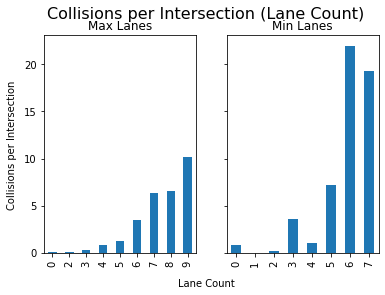

In [97]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
(data_df[['max_lanes', 'geohash']]['max_lanes'].value_counts()/stats['max_lanes']).plot.bar(ax=axes[0])
axes[0].title.set_text("Max Lanes")
(data_df[['min_lanes', 'geohash']]['min_lanes'].value_counts()/stats['min_lanes']).plot.bar(ax=axes[1])
axes[1].title.set_text("Min Lanes")
fig.text(0.04, 0.5, 'Collisions per Intersection', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Lane Count', ha='center')
fig.suptitle("Collisions per Intersection (Lane Count)", fontsize=16)
plt.show()

NameError: name 'max_width_binned' is not defined

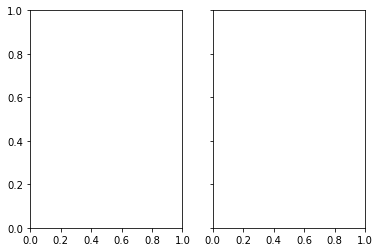

In [112]:
# Is there a collision?
max_width_per_lane = create_bins_10(data_df[['max_width', 'geohash']].drop_duplicates(), 'max_width')
min_width_binned = create_bins_10(data_df[['min_width', 'geohash']].drop_duplicates(), 'min_width')
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
(max_width_binned['max_width_bin'].value_counts()/stats['max_width_bin']).plot.bar(ax=axes[0])
axes[0].title.set_text("Max Widths Binned")
(min_width_binned['min_width_bin'].value_counts()/stats['min_width_bin']).plot.bar(ax=axes[1])
axes[1].title.set_text("Min Widths Binned")
del max_width_binned
del min_width_binned
fig.text(0.04, 0.5, 'Distrib of Intersections with a Collision', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Binned Width (x < value < x+10)', ha='center')
plt.show()